In [47]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score,\
classification_report, log_loss, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

#########################################################################

%matplotlib inline
pd.set_option("max_columns",90, "max_rows", 90)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys 
sys.path.insert(0, 'C:\\Users\\qzhang\\PycharmProjects\\Mei')
from utility import model_fit
from utils import data_prep

from sklearn.preprocessing import StandardScaler

# read data
raw_df = pd.read_csv('..\Data\Gse_panel_current_sample_raw.csv')

In [48]:
# split sample set
X_train, X_val, X_test, y_train, y_val, y_test = data_prep(raw_df)

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [49]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_sample(X_train, y_train)
print(X_res.shape)
print(y_res.shape)
print(np.sum(y_res))

X_train = X_res
y_train = y_res

(1436842, 46)
(1436842,)
718421


### One hidden layer NN

In [45]:
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Nadam
from keras.layers import Dropout
from keras import backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [53]:
model.load_weights("weights.hdf5")
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])  # higher learning rate, converges faster

In [56]:
# K.clear_session()  # cause python crash
# tf.reset_default_graph() 

model = Sequential()
model.add(Dense(30, 
                activation='relu', 
                input_dim=X_train.shape[1], 
                # kernel_regularizer=regularizers.l2(0.001),
                kernel_initializer='random_uniform'))  #  
model.add(Dropout(0.2))
model.add(Dense(30, 
                activation='relu', 
                input_dim=X_train.shape[1], 
                # kernel_regularizer=regularizers.l2(0.001),
                kernel_initializer='random_uniform'))
# model.add(LeakyReLU(alpha=0.5))
# model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(1, 
                activation='sigmoid',
                kernel_initializer='random_normal'))

#opt = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])  # higher learning rate, converges faster

print(model.summary())
ba_siz_train = 128   # smaller batch size, converges faster 
ba_siz_pred = 128

csv_logger = CSVLogger('training.log')
check_pointer = ModelCheckpoint(filepath='weights.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
cb_list = [check_pointer, early_stopper]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, 
                    batch_size=ba_siz_train, callbacks=cb_list, shuffle=True, verbose=2)  # , class_weight={0:1, 1:500}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 30)                1410      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 31        
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________
None
Train on 1436842 samples, validate on 179996 samples
Epoch 1/20
 - 76s - loss: 0.4064 - acc: 0.8215 - val_loss: 0.3785 - val_acc: 0.785

In [16]:
# history = model.fit(X_train, y_train, validation_split=0.2, initial_epoch=1, epochs=5, batch_size=ba_siz_train, shuffle=True, verbose=2) # , class_weight={0:1, 1:500}

179996/179996 [==============================] - 9s 51us/step
['loss', 'acc'] [0.3280771318984118, 0.826340585346341]


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks', 'PR_AUC': 0.017817258487256224, 'ROC_AUC': 0.8224331915615056, 'Expeted num of D60-D90': 30838.523, 'Actual num of D60-D90': 423, 'F score': 0.01129305477131564, 'G mean': 0.7384951241673647}


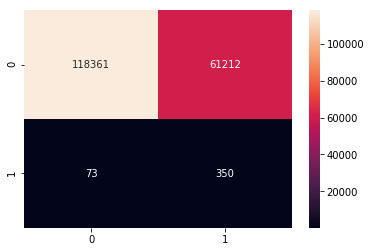

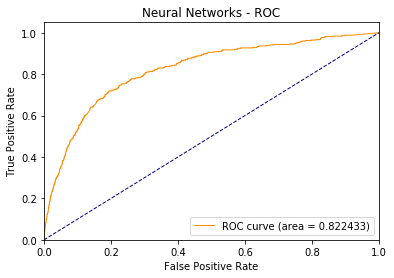

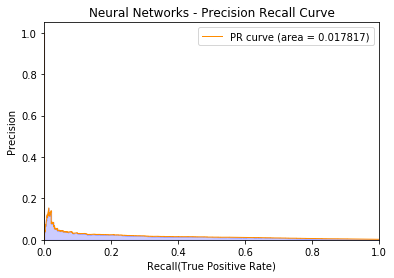

In [57]:
# evaluate - return loss and any other metrics requested, batch size should as large as possible when evaluating or predicting
scores = model.evaluate(X_val, y_val, batch_size=ba_siz_pred)   
print(model.metrics_names, scores)

# predict 
prob_pos = model.predict(X_val, batch_size=ba_siz_pred, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)
# sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test, batch_size=400, verbose=0)), annot=True, fmt="d")

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_val, prob_pos)
fpr, tpr, _ = roc_curve(y_val, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_val, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)

op = {'Classifier': 'Neural Networks',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_val),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC')
plt.legend(loc="lower right")
plt.show()

# PLOT - PR_AUC
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve')
plt.legend(loc="upper right")
plt.show()

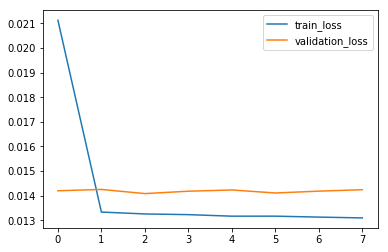

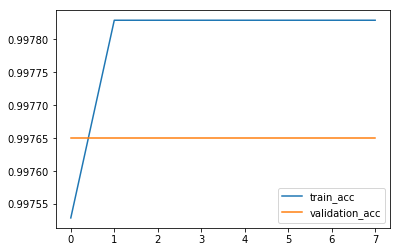

In [36]:
h = history.history

plt.figure()
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='validation_loss')
plt.legend()
plt.show()                            
plt.figure()
plt.plot(h['acc'], label='train_acc')
plt.plot(h['val_acc'], label='validation_acc')
plt.legend()
plt.show()

# 
# The training loss is the average of the losses over each batch of training data. 
# Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. 
# On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks Training Set', 'PR_AUC': 0.9293620858283114, 'ROC_AUC': 0.9514836014190522, 'Expeted num of D60-D90': 734591.6, 'Actual num of D60-D90': 718421, 'F score': 0.8540618166234042, 'G mean': 0.8113255403797319}


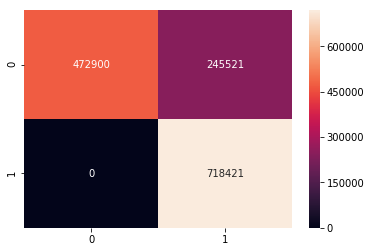

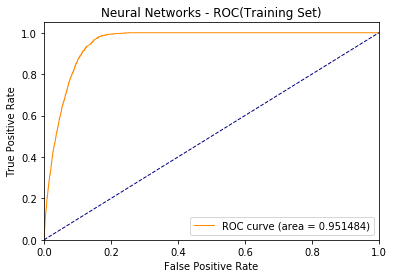

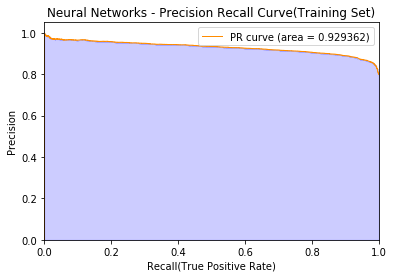

In [58]:
# predict 
prob_pos = model.predict(X_train, batch_size=ba_siz_pred, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_train, prob_pos)
fpr, tpr, _ = roc_curve(y_train, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_train, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_train, y_pred)
g_mean = geometric_mean_score(y_train, y_pred)

op = {'Classifier': 'Neural Networks Training Set',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_train),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC(Training Set)')
plt.legend(loc="lower right")
plt.show()

# PLOT - PR_AUC
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve(Training Set)')
plt.legend(loc="upper right")
plt.show()

In [1]:
138600 / 3600 / 24

1.6041666666666667

In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
